In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import transforms
from torch.nn.functional import relu
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import math

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") #using gpu
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda:0


In [3]:
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

Minimum value: 0.0117647061124444
Maximum value: 1.0


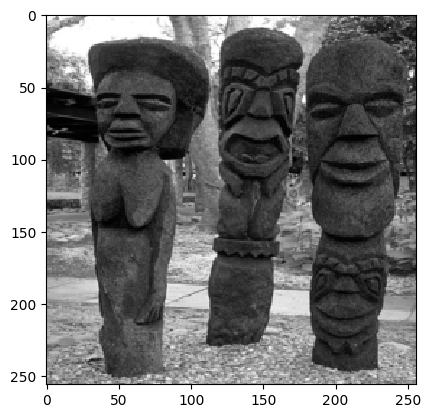

In [4]:
image = Image.open("blurImages/test001.png")
testOutput = preprocess(image).unsqueeze(0)

min_value = np.min(testOutput.squeeze(0).cpu().numpy())
max_value = np.max(testOutput.squeeze(0).cpu().numpy())
print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")
plt.imshow(testOutput.squeeze().numpy(),cmap='gray',interpolation='none')

In [5]:
class UNetDenoise(nn.Module):
    #layers definition
    def __init__(self): #constructor for uNetDenoise
        super().__init__() #constructor of parent class to init inherited attributes
        #Encoder portion, with 256x256x3 input. Padding: same for 3x3 convolutions

        #1st downsample layer
        self.conv11 = nn.Conv2d(2,64,kernel_size=3, padding=1) #dataset images are black and white
        self.conv12 = nn.Conv2d(64,64, kernel_size=3, padding=1) #keep padding same, (kernselSize-1)/2
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        #2nd downsample layer
        self.conv21 = nn.Conv2d(64,128,kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(128,128,kernel_size=3, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        #3rd downsample layer
        self.conv31 = nn.Conv2d(128,256,kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(256,256,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2)

        #4th downsample layer
        self.conv41 = nn.Conv2d(256,512,kernel_size=3, padding=1)
        self.conv42 = nn.Conv2d(512,512,kernel_size=3, padding=1)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2)

        #bottle neck
        self.conv51 = nn.Conv2d(512,1024,kernel_size=3, padding=1)
        self.conv52 = nn.Conv2d(1024,1024,kernel_size=3, padding=1)

        #upsample 1
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #1024, but half 
        self.u11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.u12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        #upsample 2
        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.u21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.u22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        #upsample 3
        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.u31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.u32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #upsample 4
        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.u41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.u42 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        #encoder forward
        xconv11 = relu(self.conv11(x))
        xconv12 = relu(self.conv12(xconv11))
        xpool1 = self.pool1(xconv12)

        xconv21 = relu(self.conv21(xpool1))
        xconv22 = relu(self.conv22(xconv21))
        xpool2 = self.pool2(xconv22)

        xconv31 = relu(self.conv31(xpool2))
        xconv32 = relu(self.conv32(xconv31))
        xpool3 = self.pool3(xconv32)

        xconv41 = relu(self.conv41(xpool3))
        xconv42 = relu(self.conv42(xconv41))
        xpool4 = self.pool4(xconv42)

        xconv51 = relu(self.conv51(xpool4))
        xconv52 = relu(self.conv52(xconv51))

        #decoder forward 
        xup1 = self.upconv1(xconv52)
        xu11 = torch.cat([xup1, xconv42], dim=1)
        xd11 = relu(self.u11(xu11))
        xd12 = relu(self.u12(xd11))

        xup2 = self.upconv2(xd12)
        xu22 = torch.cat([xup2, xconv32], dim=1)
        xd21 = relu(self.u21(xu22))
        xd22 = relu(self.u22(xd21))

        xup3 = self.upconv3(xd22)
        xu33 = torch.cat([xup3, xconv22], dim=1)
        xd31 = relu(self.u31(xu33))
        xd32 = relu(self.u32(xd31))

        xup4 = self.upconv4(xd32)
        xu44 = torch.cat([xup4, xconv12], dim=1)
        xd41 = relu(self.u41(xu44))
        xd42 = relu(self.u42(xd41))

        return xd42

In [6]:
kernel_size = 9
if kernel_size%2 == 0: #kernel size should be odd
    kernel_size = kernel_size-1

In [7]:
def create_gaussian_kernel(kernel_size=9, sigma=1.5):
    
    x = torch.arange(kernel_size) - (kernel_size - 1) / 2
    y = x.view(kernel_size, 1)
    x2y2 = x**2 + y**2
    
    gaussian_kernel = torch.exp(-x2y2 / (2 * sigma**2))
    gaussian_kernel = gaussian_kernel / (2 * np.pi * sigma**2)
    
    gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
    return gaussian_kernel

In [8]:
#noise level map
def genNoiseMap(image, sigmaNorm):
    noiselvlMap = torch.full_like(image, sigmaNorm)
    return noiselvlMap
def combineImgandMap(imageNoised, noiselvlMap): #input image needs to be noised
    combinedInput = torch.cat((imageNoised, noiselvlMap), dim=1)
    return combinedInput
def addNoiseMap(imageNoised, sigmaNorm): #image needs to be noised, sigma should be normalized?
    noiselvlMap = genNoiseMap(imageNoised, sigmaNorm)
    return combineImgandMap(imageNoised, noiselvlMap)

In [9]:
class BlurModel(nn.Module):
    def __init__(self):
        super(BlurModel, self).__init__()
        
        self.k= create_gaussian_kernel(kernel_size, 1.5)

        self.k = self.k.view(1,1,kernel_size,kernel_size)
        self.k = self.k.to(device)
    # def forward(self, x, sigma=0):
    #     # A y

    #     #need new padding size with larger kernel
    #     padding_size = kernel_size//2
        
    #     x_padded = F.pad(x, (padding_size,padding_size,padding_size,padding_size), mode='circular')
    #     #applying blur and noise
    #     y = F.conv2d(x_padded, self.k) + sigma * torch.randn_like(x)
    #     return y

    def forward(self, x):
        # A y

        #need new padding size with larger kernel
        padding_size = kernel_size//2
        
        x_padded = F.pad(x, (padding_size,padding_size,padding_size,padding_size), mode='circular')
        #applying blur without noise
        y = F.conv2d(x_padded, self.k)
        return y
    
    def tran(self, y):
        # A^T y
#         x = NotImplemented # hint: transpose the blur kernel
        self.k = torch.transpose(self.k, 0, 1)

        #need new padding size with larger kernel
        padding_size = kernel_size//2
        
        y_padded = F.pad(y, (padding_size, padding_size, padding_size, padding_size), mode='circular')
        #kTranposed = self.k.t()
        x = F.conv2d(y_padded, self.k, padding=0) #self.k is symmetric
        return x
    
    def grad(self, x, y):
        # gradient of 0.5 || Ax - y ||^2 --> grad = A^T(Ax - y)
        g = self.tran( self.forward(x) - y )
        return g

    def calcLoss(self, x, y):
        diff = self.forward(x) - y
        diffSquared = diff ** 2
        return 0.5*torch.sum(diffSquared)


In [10]:
def psnrCalc(mse, max):
    return 10*np.log10((max**2)/mse)


In [11]:
def run_PnP_ISTA(
             x0,
             A, 
             denoiser,
             meas, 
             stepsize,
             gt_img, 
             max_iter,
             sigmaNoiseMap,
             meas_sigma,
            ):
    # ############################
    # A basic implementation of PnP ISTA
    # ############################

    #initializing and adding noise
    x = x0 + meas_sigma * torch.randn_like(x0)
    with torch.no_grad():
        for i in tqdm(range(max_iter)):
            # Look at PnP ISTA update steps
            
            z = x - stepsize*A.grad(x, meas) #prev x - stepsize*grad(prev x)

            #adding noise map to z:
            z = addNoiseMap(z, sigmaNoiseMap)

            #plug into denoiser
            x = denoiser(z)
        
            #Feel free to add psnr/ssim tracking
            #track loss of (y-AX)^2
            #check if fista is running properly: set x=z, initailize image to zeros, simga=0 and you'll converge
            if i % 10 == 0:
                gt_img_np = gt_img.cpu().detach().numpy() if gt_img.is_cuda else gt_img.numpy()
                x_np = x.cpu().detach().numpy() if x.is_cuda else x.detach().numpy()
                meas_np = meas.cpu().detach().numpy() if meas.is_cuda else x.detach().numpy()
                #psnr of output
                mseTerm = mse(gt_img_np,x_np)
                curPsnr = psnrCalc(mseTerm, 1)
                curLoss = A.calcLoss(x, meas)
        
                #psnr of measurement
                mseTermMeas = mse(gt_img_np,meas_np)
                curPsnrMeas = psnrCalc(mseTermMeas, 1)

                psnrList.append(curPsnr)
                lossList.append(curLoss) #x is clean image, y is measurement
                print(f"At iter {i}, loss is: {curLoss}, PSNR of output is: {curPsnr}, PSNR of input is: {curPsnrMeas}");
    return x

In [12]:
findBestStepSize = False

In [13]:
max_iter = 200
stepsize = [2, 1, 0.9, 0.8, 0.5, 0.3, 0.1, 0.05, 0.01] # play with this
meas_sigma = 15 / 255 # play with this (note that it does not need to be same as the sigma you used for training)
bestPsnr = float('-inf')
bestStepSize = 0
#sigma for noise map
sigmaSampled = torch.randint(1,50,(1,1)).item() #each image have diff sigma
sigmaNoiseMap = sigmaSampled/255

A = BlurModel().to(device) # forward model

clean_img = preprocess(image).unsqueeze(0)
clean_img = clean_img.to(device)
blurry_img = A(clean_img)

network = UNetDenoise()
network.load_state_dict(torch.load('denoiserModelBestWeightswNoiseMap.pth')) # Your NN you trained 
#denoiserFinalWeights.pth denoiserModelBestWeights.pth denoiserFinalWeightsEarlyStopped.pth denoiserModelBestWeightsEarlyStopped.pth denoiserFinalWeightswNoiseMap.pth 
network.eval()

#x0 = torch.zeros_like(blurry_img)
x0 = blurry_img
network.to(device)
blurry_img = blurry_img.to(device)

x0 = x0.to(device)
# if findBestStepSize:
#     for aStepsize in stepsize:
#         lossList = list()
#         psnrList = list()
#         print(f'step size of: {aStepsize}')
#         recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
#                              A = A, 
#                              denoiser = network,
#                              meas = blurry_img, 
#                              stepsize = aStepsize,
#                              gt_img = clean_img, 
#                              max_iter = max_iter
#                         )
#         print(f'final psnr with stepsize {aStepsize}: {psnrList[-1]}')
    
#         if psnrList[-1] > bestPsnr:
#             bestPsnr = psnrList[-1]
#             bestStepSize = aStepsize
    
#         fig, ax = plt.subplots(1,4)
#         plt.title(f'At StepSize: {aStepsize} clean, pre reconstruction, measurment, and estimated images')
#         ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
#         ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
#         ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
#         ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')


  0%|          | 1/500 [00:00<01:49,  4.55it/s]

At iter 0, loss is: 6.717825889587402, PSNR of output is: 24.683132070893564, PSNR of input is: 24.799891158716747


  4%|▍         | 21/500 [00:00<00:12, 37.02it/s]

At iter 10, loss is: 4.98703670501709, PSNR of output is: 25.0563528688473, PSNR of input is: 24.799891158716747
At iter 20, loss is: 5.018174171447754, PSNR of output is: 25.04166052274953, PSNR of input is: 24.799891158716747


  8%|▊         | 41/500 [00:01<00:10, 43.97it/s]

At iter 30, loss is: 5.031618595123291, PSNR of output is: 25.033282598524586, PSNR of input is: 24.799891158716747
At iter 40, loss is: 5.0372796058654785, PSNR of output is: 25.029303765277167, PSNR of input is: 24.799891158716747


 10%|█         | 51/500 [00:01<00:09, 45.52it/s]

At iter 50, loss is: 5.038730621337891, PSNR of output is: 25.027924953921364, PSNR of input is: 24.799891158716747


 12%|█▏        | 61/500 [00:01<00:09, 46.52it/s]

At iter 60, loss is: 5.0383195877075195, PSNR of output is: 25.027937910230165, PSNR of input is: 24.799891158716747


 14%|█▍        | 71/500 [00:01<00:09, 46.95it/s]

At iter 70, loss is: 5.037352561950684, PSNR of output is: 25.02845614732704, PSNR of input is: 24.799891158716747
At iter 80, loss is: 5.036465644836426, PSNR of output is: 25.02901720043317, PSNR of input is: 24.799891158716747


 18%|█▊        | 91/500 [00:02<00:08, 47.61it/s]

At iter 90, loss is: 5.035861968994141, PSNR of output is: 25.029453459687264, PSNR of input is: 24.799891158716747


 20%|██        | 101/500 [00:02<00:08, 47.90it/s]

At iter 100, loss is: 5.035540580749512, PSNR of output is: 25.029730540954304, PSNR of input is: 24.799891158716747


 22%|██▏       | 111/500 [00:02<00:08, 47.96it/s]

At iter 110, loss is: 5.035427093505859, PSNR of output is: 25.029870917037222, PSNR of input is: 24.799891158716747


 24%|██▍       | 121/500 [00:02<00:07, 48.08it/s]

At iter 120, loss is: 5.035431861877441, PSNR of output is: 25.029913978660833, PSNR of input is: 24.799891158716747


 26%|██▌       | 131/500 [00:02<00:07, 48.09it/s]

At iter 130, loss is: 5.035483360290527, PSNR of output is: 25.029905545567, PSNR of input is: 24.799891158716747
At iter 140, loss is: 5.035541534423828, PSNR of output is: 25.029877802945606, PSNR of input is: 24.799891158716747


 32%|███▏      | 161/500 [00:03<00:06, 48.44it/s]

At iter 150, loss is: 5.035586357116699, PSNR of output is: 25.02984945029732, PSNR of input is: 24.799891158716747
At iter 160, loss is: 5.035611629486084, PSNR of output is: 25.029828648500896, PSNR of input is: 24.799891158716747


 34%|███▍      | 171/500 [00:03<00:06, 48.41it/s]

At iter 170, loss is: 5.035622596740723, PSNR of output is: 25.029816610819115, PSNR of input is: 24.799891158716747


 38%|███▊      | 191/500 [00:04<00:06, 48.39it/s]

At iter 180, loss is: 5.035624027252197, PSNR of output is: 25.029811758906607, PSNR of input is: 24.799891158716747
At iter 190, loss is: 5.035620212554932, PSNR of output is: 25.029811707132886, PSNR of input is: 24.799891158716747


 40%|████      | 201/500 [00:04<00:06, 48.38it/s]

At iter 200, loss is: 5.035614967346191, PSNR of output is: 25.02981384996169, PSNR of input is: 24.799891158716747
At iter 210, loss is: 5.035610675811768, PSNR of output is: 25.029816384021757, PSNR of input is: 24.799891158716747


 44%|████▍     | 221/500 [00:04<00:05, 48.24it/s]

At iter 220, loss is: 5.03560733795166, PSNR of output is: 25.02981873275305, PSNR of input is: 24.799891158716747


 48%|████▊     | 241/500 [00:05<00:05, 48.29it/s]

At iter 230, loss is: 5.035605430603027, PSNR of output is: 25.029820332006153, PSNR of input is: 24.799891158716747
At iter 240, loss is: 5.035605430603027, PSNR of output is: 25.029821148801652, PSNR of input is: 24.799891158716747


 52%|█████▏    | 261/500 [00:05<00:04, 48.34it/s]

At iter 250, loss is: 5.035605430603027, PSNR of output is: 25.029821400981803, PSNR of input is: 24.799891158716747
At iter 260, loss is: 5.0356059074401855, PSNR of output is: 25.029821435904882, PSNR of input is: 24.799891158716747


 56%|█████▌    | 281/500 [00:06<00:04, 48.41it/s]

At iter 270, loss is: 5.0356059074401855, PSNR of output is: 25.0298213808852, PSNR of input is: 24.799891158716747
At iter 280, loss is: 5.035606384277344, PSNR of output is: 25.02982123984826, PSNR of input is: 24.799891158716747


 58%|█████▊    | 291/500 [00:06<00:04, 48.39it/s]

At iter 290, loss is: 5.035606384277344, PSNR of output is: 25.02982107694555, PSNR of input is: 24.799891158716747


 60%|██████    | 301/500 [00:06<00:04, 48.02it/s]

At iter 300, loss is: 5.035606384277344, PSNR of output is: 25.02982101677069, PSNR of input is: 24.799891158716747


 64%|██████▍   | 321/500 [00:06<00:03, 47.82it/s]

At iter 310, loss is: 5.035606384277344, PSNR of output is: 25.029821028918203, PSNR of input is: 24.799891158716747
At iter 320, loss is: 5.035606384277344, PSNR of output is: 25.029821008749714, PSNR of input is: 24.799891158716747


 66%|██████▌   | 331/500 [00:07<00:03, 47.90it/s]

At iter 330, loss is: 5.035606384277344, PSNR of output is: 25.029821019035804, PSNR of input is: 24.799891158716747


 68%|██████▊   | 341/500 [00:07<00:03, 47.62it/s]

At iter 340, loss is: 5.035605430603027, PSNR of output is: 25.029821226331322, PSNR of input is: 24.799891158716747


 70%|███████   | 351/500 [00:07<00:03, 47.43it/s]

At iter 350, loss is: 5.035606384277344, PSNR of output is: 25.029821152776893, PSNR of input is: 24.799891158716747


 72%|███████▏  | 361/500 [00:07<00:02, 47.63it/s]

At iter 360, loss is: 5.035606384277344, PSNR of output is: 25.02982110977227, PSNR of input is: 24.799891158716747


 76%|███████▌  | 381/500 [00:08<00:02, 47.69it/s]

At iter 370, loss is: 5.035606384277344, PSNR of output is: 25.029821163770784, PSNR of input is: 24.799891158716747
At iter 380, loss is: 5.035606384277344, PSNR of output is: 25.02982121095275, PSNR of input is: 24.799891158716747


 78%|███████▊  | 391/500 [00:08<00:02, 47.95it/s]

At iter 390, loss is: 5.035606384277344, PSNR of output is: 25.02982111707095, PSNR of input is: 24.799891158716747


 80%|████████  | 401/500 [00:08<00:02, 48.21it/s]

At iter 400, loss is: 5.0356059074401855, PSNR of output is: 25.029821160438978, PSNR of input is: 24.799891158716747


 82%|████████▏ | 411/500 [00:08<00:01, 48.24it/s]

At iter 410, loss is: 5.035605430603027, PSNR of output is: 25.029821210867645, PSNR of input is: 24.799891158716747
At iter 420, loss is: 5.035606384277344, PSNR of output is: 25.029821213453847, PSNR of input is: 24.799891158716747


 88%|████████▊ | 441/500 [00:09<00:01, 48.53it/s]

At iter 430, loss is: 5.035606384277344, PSNR of output is: 25.02982119345235, PSNR of input is: 24.799891158716747
At iter 440, loss is: 5.035605430603027, PSNR of output is: 25.029821246362566, PSNR of input is: 24.799891158716747


 90%|█████████ | 451/500 [00:09<00:01, 48.61it/s]

At iter 450, loss is: 5.0356059074401855, PSNR of output is: 25.029821251123874, PSNR of input is: 24.799891158716747


 92%|█████████▏| 461/500 [00:09<00:00, 48.67it/s]

At iter 460, loss is: 5.0356059074401855, PSNR of output is: 25.029821247507268, PSNR of input is: 24.799891158716747
At iter 470, loss is: 5.035606384277344, PSNR of output is: 25.029821177125623, PSNR of input is: 24.799891158716747


 96%|█████████▌| 481/500 [00:10<00:00, 48.60it/s]

At iter 480, loss is: 5.035606384277344, PSNR of output is: 25.029821127112516, PSNR of input is: 24.799891158716747
At iter 490, loss is: 5.0356059074401855, PSNR of output is: 25.02982114804588, PSNR of input is: 24.799891158716747


100%|██████████| 500/500 [00:10<00:00, 48.00it/s]


(-0.5, 255.5, 255.5, -0.5)

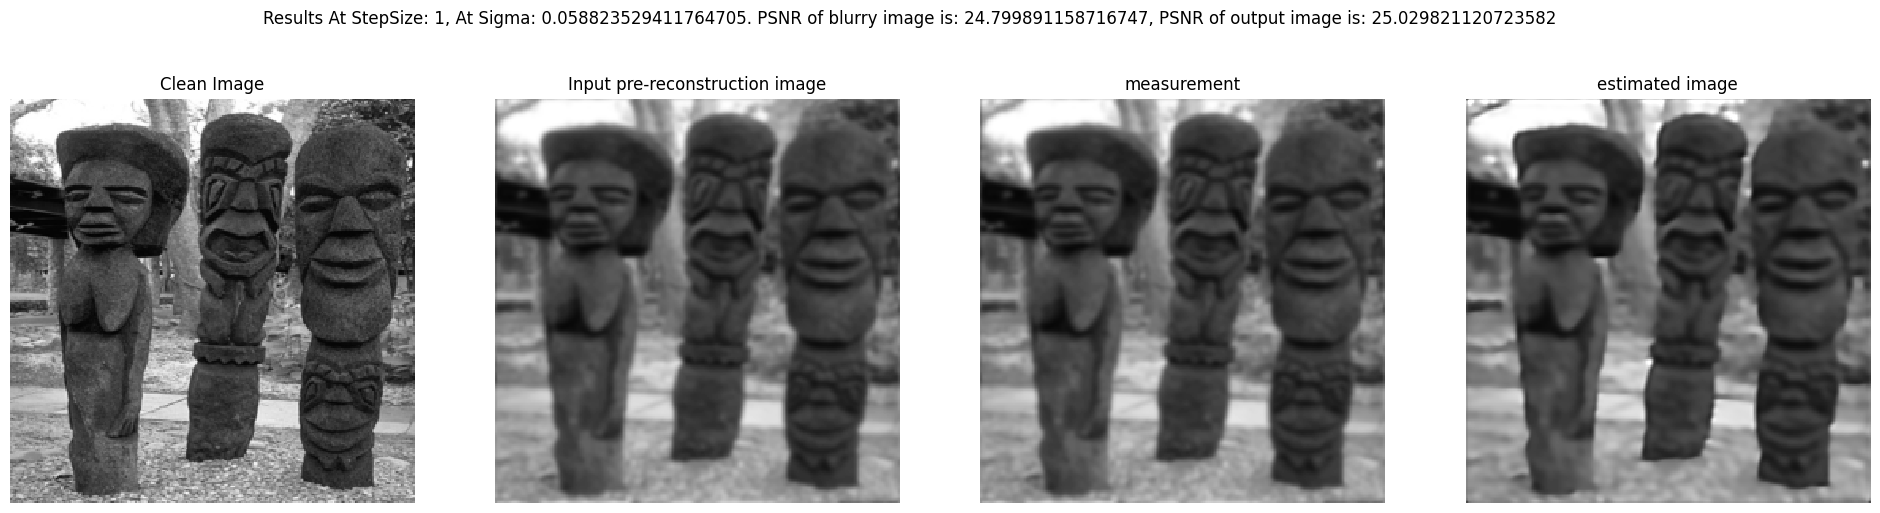

In [14]:
#best step size is found to be 1
lossList = list()
psnrList = list()
recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
                         A = A, 
                         denoiser = network,
                         meas = blurry_img, 
                         stepsize = 1,
                         gt_img = clean_img, 
                         max_iter = 500,
                         sigmaNoiseMap = sigmaNoiseMap,
                         meas_sigma = meas_sigma
                    )

blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon_np = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon_np)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

fig, ax = plt.subplots(1,4, figsize=(24,6))

fig.suptitle(f'Results At StepSize: {1}, At Sigma: {meas_sigma}. PSNR of blurry image is: {finalPsnrMeas}, PSNR of output image is: {finalPsnrOutput}')

ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[0].set_title("Clean Image", fontsize=12)
ax[0].axis('off')
ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[1].set_title("Input pre-reconstruction image", fontsize=12)
ax[1].axis('off')
ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[2].set_title("measurement", fontsize=12)
ax[2].axis('off')
ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[3].set_title("estimated image", fontsize=12)
ax[3].axis('off')

In [15]:
blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

print(f'Final result PSNR of blurred image {finalPsnrMeas}')
print(f'Final result PSNR of reconstructed image {finalPsnrOutput}')

Final result PSNR of blurred image 24.799891158716747
Final result PSNR of reconstructed image 25.029821120723582


In [16]:
import scipy

In [17]:
def objFuncStepSize(stepsize):
    imgRecon = run_PnP_ISTA(x0=x0, A=A, denoiser=network, meas=blurry_img, stepsize=1e-6, gt_img=clean_img, max_iter=200, sigmaNoiseMap = sigmaNoiseMap, meas_sigma=15/255) #pass in sigma,
    blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
    clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.detach().numpy()
    imgRecon_np = imgRecon.cpu().detach().numpy() if isinstance(imgRecon, torch.Tensor) else imgRecon
    mseTermRecon = mse(clean_img_np, imgRecon_np)
    mseTermBlurred = mse(clean_img_np, blurry_img_np)
    return -psnrCalc(mseTermRecon, 1)

In [18]:
bestStepsize = scipy.optimize.fminbound(objFuncStepSize,1e-6,2,xtol=1e-3,maxfun=20,disp=3)

  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.899791717529297, PSNR of output is: 23.991318581644045, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 47.04it/s]

At iter 10, loss is: 72.29595947265625, PSNR of output is: 21.65978288152275, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.63it/s]

At iter 20, loss is: 156.41519165039062, PSNR of output is: 19.9695583504776, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.84it/s]

At iter 30, loss is: 250.34329223632812, PSNR of output is: 18.733445724034702, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 48.03it/s]

At iter 40, loss is: 347.02935791015625, PSNR of output is: 17.776037031033816, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.66it/s]

At iter 50, loss is: 443.361083984375, PSNR of output is: 17.004629597515834, PSNR of input is: 24.799891158716747
At iter 60, loss is: 539.1494140625, PSNR of output is: 16.360469094271597, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 48.02it/s]

At iter 70, loss is: 636.06396484375, PSNR of output is: 15.80158637344211, PSNR of input is: 24.799891158716747
At iter 80, loss is: 734.6995849609375, PSNR of output is: 15.305316248726085, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 48.05it/s]

At iter 90, loss is: 833.0096435546875, PSNR of output is: 14.867741086753313, PSNR of input is: 24.799891158716747
At iter 100, loss is: 930.4229125976562, PSNR of output is: 14.477280823603266, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 48.18it/s]

At iter 110, loss is: 1026.92529296875, PSNR of output is: 14.123806031425644, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 48.16it/s]

At iter 120, loss is: 1122.306396484375, PSNR of output is: 13.801558940547308, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 48.13it/s]

At iter 130, loss is: 1217.0794677734375, PSNR of output is: 13.503537408411812, PSNR of input is: 24.799891158716747
At iter 140, loss is: 1311.319580078125, PSNR of output is: 13.226285008073067, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.43it/s]

At iter 150, loss is: 1404.47216796875, PSNR of output is: 12.968977956682778, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.50it/s]

At iter 160, loss is: 1496.43994140625, PSNR of output is: 12.729768214872294, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.61it/s]

At iter 170, loss is: 1587.675537109375, PSNR of output is: 12.506281392634618, PSNR of input is: 24.799891158716747


 96%|█████████▌| 191/200 [00:04<00:00, 47.47it/s]

At iter 180, loss is: 1677.306396484375, PSNR of output is: 12.298659223463176, PSNR of input is: 24.799891158716747
At iter 190, loss is: 1765.81689453125, PSNR of output is: 12.103606963447891, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.64it/s]


 
 Func-count     x          f(x)          Procedure
    1       0.763933     -11.9378        initial


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.961799621582031, PSNR of output is: 24.01475955243958, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:03, 48.06it/s]

At iter 10, loss is: 72.04226684570312, PSNR of output is: 21.66584950987624, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 48.09it/s]

At iter 20, loss is: 155.6489715576172, PSNR of output is: 19.980746259835747, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 48.16it/s]

At iter 30, loss is: 249.9178924560547, PSNR of output is: 18.737469693150523, PSNR of input is: 24.799891158716747
At iter 40, loss is: 348.21661376953125, PSNR of output is: 17.766374483408896, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 48.14it/s]

At iter 50, loss is: 446.5693054199219, PSNR of output is: 16.98437842264414, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 48.12it/s]

At iter 60, loss is: 544.7737426757812, PSNR of output is: 16.331485879630897, PSNR of input is: 24.799891158716747
At iter 70, loss is: 644.36572265625, PSNR of output is: 15.764589065943266, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 48.04it/s]

At iter 80, loss is: 746.1671142578125, PSNR of output is: 15.259734828210634, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.77it/s]

At iter 90, loss is: 848.7698974609375, PSNR of output is: 14.810008445029077, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.60it/s]

At iter 100, loss is: 949.8935546875, PSNR of output is: 14.411815823755171, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.86it/s]

At iter 110, loss is: 1049.2022705078125, PSNR of output is: 14.05543845253018, PSNR of input is: 24.799891158716747
At iter 120, loss is: 1146.3114013671875, PSNR of output is: 13.733758819367141, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.36it/s]

At iter 130, loss is: 1241.22900390625, PSNR of output is: 13.440673281834686, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 47.31it/s]

At iter 140, loss is: 1334.0595703125, PSNR of output is: 13.171526718632286, PSNR of input is: 24.799891158716747
At iter 150, loss is: 1425.07275390625, PSNR of output is: 12.922686458894407, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.34it/s]

At iter 160, loss is: 1514.709228515625, PSNR of output is: 12.690961922389484, PSNR of input is: 24.799891158716747
At iter 170, loss is: 1602.1783447265625, PSNR of output is: 12.47598506487546, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.36it/s]

At iter 180, loss is: 1689.2353515625, PSNR of output is: 12.269992746929733, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.58it/s]


At iter 190, loss is: 1778.186767578125, PSNR of output is: 12.06225766774242, PSNR of input is: 24.799891158716747
    2        1.23607     -11.8829        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.341527938842773, PSNR of output is: 23.981015024991244, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.30it/s]

At iter 10, loss is: 73.18992614746094, PSNR of output is: 21.63806749284369, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.43it/s]

At iter 20, loss is: 157.55755615234375, PSNR of output is: 19.951876585267627, PSNR of input is: 24.799891158716747
At iter 30, loss is: 252.72506713867188, PSNR of output is: 18.706281835206962, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 47.16it/s]

At iter 40, loss is: 351.85504150390625, PSNR of output is: 17.73523961228595, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.15it/s]

At iter 50, loss is: 450.94488525390625, PSNR of output is: 16.953298018609082, PSNR of input is: 24.799891158716747
At iter 60, loss is: 549.5455322265625, PSNR of output is: 16.302438376320328, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 47.54it/s]

At iter 70, loss is: 649.720947265625, PSNR of output is: 15.736285582408991, PSNR of input is: 24.799891158716747
At iter 80, loss is: 751.91064453125, PSNR of output is: 15.233493180431745, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.78it/s]

At iter 90, loss is: 853.9461669921875, PSNR of output is: 14.789644878226888, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.95it/s]

At iter 100, loss is: 954.6431274414062, PSNR of output is: 14.395359898332167, PSNR of input is: 24.799891158716747
At iter 110, loss is: 1052.62890625, PSNR of output is: 14.044507495458197, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 48.16it/s]

At iter 120, loss is: 1148.4176025390625, PSNR of output is: 13.727094898038676, PSNR of input is: 24.799891158716747
At iter 130, loss is: 1242.715087890625, PSNR of output is: 13.435519700798661, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 48.14it/s]

At iter 140, loss is: 1335.90771484375, PSNR of output is: 13.164487132859144, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.58it/s]

At iter 150, loss is: 1427.32421875, PSNR of output is: 12.913163755467389, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.33it/s]

At iter 160, loss is: 1517.87255859375, PSNR of output is: 12.678076708038613, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.02it/s]

At iter 170, loss is: 1607.38818359375, PSNR of output is: 12.458389363923793, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.14it/s]

At iter 180, loss is: 1696.34033203125, PSNR of output is: 12.251410494013344, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.40it/s]


At iter 190, loss is: 1784.6229248046875, PSNR of output is: 12.055695611760733, PSNR of input is: 24.799891158716747
    3       0.472137     -11.8891        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 15.048585891723633, PSNR of output is: 23.998571502533387, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.24it/s]

At iter 10, loss is: 72.235595703125, PSNR of output is: 21.663220090105774, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.15it/s]

At iter 20, loss is: 155.973388671875, PSNR of output is: 19.975011589228387, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.67it/s]

At iter 30, loss is: 249.73080444335938, PSNR of output is: 18.736777320895072, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 48.07it/s]

At iter 40, loss is: 347.1902770996094, PSNR of output is: 17.771627799973416, PSNR of input is: 24.799891158716747
At iter 50, loss is: 444.9046936035156, PSNR of output is: 16.99241463228529, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 48.16it/s]

At iter 60, loss is: 542.346435546875, PSNR of output is: 16.341662162284965, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 48.29it/s]

At iter 70, loss is: 640.7288818359375, PSNR of output is: 15.778766415657115, PSNR of input is: 24.799891158716747
At iter 80, loss is: 741.3787841796875, PSNR of output is: 15.277038681485887, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 48.16it/s]

At iter 90, loss is: 843.7435302734375, PSNR of output is: 14.826554398568977, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 48.21it/s]

At iter 100, loss is: 945.50927734375, PSNR of output is: 14.424250925823676, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 48.18it/s]

At iter 110, loss is: 1044.8974609375, PSNR of output is: 14.066960185180157, PSNR of input is: 24.799891158716747
At iter 120, loss is: 1141.7518310546875, PSNR of output is: 13.745372271715448, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 48.23it/s]

At iter 130, loss is: 1236.569091796875, PSNR of output is: 13.452135020013573, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 48.16it/s]

At iter 140, loss is: 1329.7193603515625, PSNR of output is: 13.182033798575162, PSNR of input is: 24.799891158716747
At iter 150, loss is: 1420.98388671875, PSNR of output is: 12.932213597090156, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 48.15it/s]

At iter 160, loss is: 1511.3214111328125, PSNR of output is: 12.698233052463724, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 48.20it/s]

At iter 170, loss is: 1599.5045166015625, PSNR of output is: 12.482204018167877, PSNR of input is: 24.799891158716747


 96%|█████████▌| 191/200 [00:03<00:00, 48.27it/s]

At iter 180, loss is: 1685.8922119140625, PSNR of output is: 12.281085420328665, PSNR of input is: 24.799891158716747
At iter 190, loss is: 1773.171630859375, PSNR of output is: 12.085207637447722, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:03<00:00, 50.06it/s]


    4       0.843057     -11.9085        parabolic


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.769477844238281, PSNR of output is: 24.019688226848203, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 48.08it/s]

At iter 10, loss is: 72.24749755859375, PSNR of output is: 21.659107776963484, PSNR of input is: 24.799891158716747
At iter 20, loss is: 156.49034118652344, PSNR of output is: 19.96480014539773, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 48.09it/s]

At iter 30, loss is: 251.23683166503906, PSNR of output is: 18.720365723408673, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 48.19it/s]

At iter 40, loss is: 350.1212158203125, PSNR of output is: 17.747908361180748, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 48.16it/s]

At iter 50, loss is: 450.046630859375, PSNR of output is: 16.957450561101805, PSNR of input is: 24.799891158716747
At iter 60, loss is: 549.9310302734375, PSNR of output is: 16.298393906459488, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 48.27it/s]

At iter 70, loss is: 651.4407348632812, PSNR of output is: 15.726253992087283, PSNR of input is: 24.799891158716747
At iter 80, loss is: 754.529052734375, PSNR of output is: 15.220421986072314, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 48.22it/s]

At iter 90, loss is: 857.0632934570312, PSNR of output is: 14.775225843469402, PSNR of input is: 24.799891158716747
At iter 100, loss is: 958.9176635742188, PSNR of output is: 14.377526699683997, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 48.21it/s]

At iter 110, loss is: 1059.1500244140625, PSNR of output is: 14.020895491375732, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 48.18it/s]

At iter 120, loss is: 1156.8199462890625, PSNR of output is: 13.699873323109193, PSNR of input is: 24.799891158716747
At iter 130, loss is: 1252.417236328125, PSNR of output is: 13.406517158415635, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 48.16it/s]

At iter 140, loss is: 1346.406982421875, PSNR of output is: 13.135147727986174, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 48.14it/s]

At iter 150, loss is: 1438.318115234375, PSNR of output is: 12.885212435002462, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 48.13it/s]

At iter 160, loss is: 1527.865234375, PSNR of output is: 12.656036337797893, PSNR of input is: 24.799891158716747
At iter 170, loss is: 1615.467529296875, PSNR of output is: 12.444163159678324, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 48.10it/s]

At iter 180, loss is: 1701.853759765625, PSNR of output is: 12.24532496638371, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:03<00:00, 50.13it/s]


At iter 190, loss is: 1787.663330078125, PSNR of output is: 12.055370778459505, PSNR of input is: 24.799891158716747
    5       0.675586     -11.8872        parabolic


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.841646194458008, PSNR of output is: 23.98959828735423, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:03, 47.65it/s]

At iter 10, loss is: 72.0147476196289, PSNR of output is: 21.66482182132482, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.78it/s]

At iter 20, loss is: 156.16246032714844, PSNR of output is: 19.970429913562036, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 48.02it/s]

At iter 30, loss is: 250.65711975097656, PSNR of output is: 18.726027719965117, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 48.06it/s]

At iter 40, loss is: 348.30145263671875, PSNR of output is: 17.761841767932676, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 48.16it/s]

At iter 50, loss is: 446.00067138671875, PSNR of output is: 16.984167353425615, PSNR of input is: 24.799891158716747
At iter 60, loss is: 543.244384765625, PSNR of output is: 16.336092773058297, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 48.14it/s]

At iter 70, loss is: 641.7097778320312, PSNR of output is: 15.774324514959483, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 48.12it/s]

At iter 80, loss is: 741.662353515625, PSNR of output is: 15.277172612353358, PSNR of input is: 24.799891158716747
At iter 90, loss is: 842.31982421875, PSNR of output is: 14.834519708511431, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 48.06it/s]

At iter 100, loss is: 943.1746826171875, PSNR of output is: 14.435570968138023, PSNR of input is: 24.799891158716747
At iter 110, loss is: 1042.4775390625, PSNR of output is: 14.07719985612069, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.32it/s]

At iter 120, loss is: 1139.652099609375, PSNR of output is: 13.753305917939452, PSNR of input is: 24.799891158716747
At iter 130, loss is: 1234.6005859375, PSNR of output is: 13.459025148917858, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 47.49it/s]

At iter 140, loss is: 1327.9583740234375, PSNR of output is: 13.187325825216128, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.40it/s]

At iter 150, loss is: 1419.1561279296875, PSNR of output is: 12.936576490108997, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.94it/s]

At iter 160, loss is: 1508.74560546875, PSNR of output is: 12.70400712465818, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.34it/s]

At iter 170, loss is: 1596.897216796875, PSNR of output is: 12.488217129368842, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.29it/s]

At iter 180, loss is: 1683.71923828125, PSNR of output is: 12.287024347452004, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.50it/s]


At iter 190, loss is: 1769.687744140625, PSNR of output is: 12.096607328451443, PSNR of input is: 24.799891158716747
    6       0.730187     -11.9332        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.981549263000488, PSNR of output is: 23.986691555147196, PSNR of input is: 24.799891158716747
At iter 10, loss is: 72.77165222167969, PSNR of output is: 21.640357812200133, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.77it/s]

At iter 20, loss is: 157.41546630859375, PSNR of output is: 19.95078203595891, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.62it/s]

At iter 30, loss is: 252.1761932373047, PSNR of output is: 18.710944000714463, PSNR of input is: 24.799891158716747
At iter 40, loss is: 349.35687255859375, PSNR of output is: 17.753825072542682, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.72it/s]

At iter 50, loss is: 445.5282897949219, PSNR of output is: 16.987666343554274, PSNR of input is: 24.799891158716747
At iter 60, loss is: 540.60400390625, PSNR of output is: 16.35038560729126, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.84it/s]

At iter 70, loss is: 636.3492431640625, PSNR of output is: 15.797946125231217, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 47.78it/s]

At iter 80, loss is: 734.00634765625, PSNR of output is: 15.30520484096225, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.39it/s]

At iter 90, loss is: 832.1773071289062, PSNR of output is: 14.866714146869457, PSNR of input is: 24.799891158716747
At iter 100, loss is: 929.2117919921875, PSNR of output is: 14.477131835996515, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.40it/s]

At iter 110, loss is: 1025.0010986328125, PSNR of output is: 14.126467472366448, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.60it/s]

At iter 120, loss is: 1120.620849609375, PSNR of output is: 13.803287409820669, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.45it/s]

At iter 130, loss is: 1215.9302978515625, PSNR of output is: 13.502879292480383, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 46.74it/s]

At iter 140, loss is: 1310.4537353515625, PSNR of output is: 13.223307065420888, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.27it/s]

At iter 150, loss is: 1404.382568359375, PSNR of output is: 12.96165713519011, PSNR of input is: 24.799891158716747
At iter 160, loss is: 1497.574951171875, PSNR of output is: 12.717505331628395, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.64it/s]

At iter 170, loss is: 1589.8720703125, PSNR of output is: 12.489608740293626, PSNR of input is: 24.799891158716747
At iter 180, loss is: 1681.7762451171875, PSNR of output is: 12.274902521750665, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.35it/s]


At iter 190, loss is: 1773.48681640625, PSNR of output is: 12.07123028623821, PSNR of input is: 24.799891158716747
    7       0.762324     -11.8972        parabolic


  6%|▌         | 11/200 [00:00<00:03, 47.64it/s]

At iter 0, loss is: 15.346290588378906, PSNR of output is: 23.980148303957726, PSNR of input is: 24.799891158716747
At iter 10, loss is: 73.68074035644531, PSNR of output is: 21.628672197063878, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.65it/s]

At iter 20, loss is: 158.4805145263672, PSNR of output is: 19.942057372981967, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.75it/s]

At iter 30, loss is: 253.99395751953125, PSNR of output is: 18.695049099504267, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 47.44it/s]

At iter 40, loss is: 352.1652526855469, PSNR of output is: 17.732426140775086, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.88it/s]

At iter 50, loss is: 448.6433410644531, PSNR of output is: 16.96720267509051, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.99it/s]

At iter 60, loss is: 543.6109008789062, PSNR of output is: 16.33401882162285, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.56it/s]

At iter 70, loss is: 639.6326293945312, PSNR of output is: 15.784024076440081, PSNR of input is: 24.799891158716747
At iter 80, loss is: 738.1458740234375, PSNR of output is: 15.29172947002854, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.25it/s]

At iter 90, loss is: 838.4075927734375, PSNR of output is: 14.848772818046802, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.82it/s]

At iter 100, loss is: 938.603515625, PSNR of output is: 14.451105005849719, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.08it/s]

At iter 110, loss is: 1037.4364013671875, PSNR of output is: 14.093454466863783, PSNR of input is: 24.799891158716747
At iter 120, loss is: 1134.001953125, PSNR of output is: 13.771018638115809, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.65it/s]

At iter 130, loss is: 1229.55859375, PSNR of output is: 13.474007577971793, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.54it/s]

At iter 140, loss is: 1324.554443359375, PSNR of output is: 13.19681989139841, PSNR of input is: 24.799891158716747
At iter 150, loss is: 1418.1571044921875, PSNR of output is: 12.939648830460303, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.34it/s]

At iter 160, loss is: 1509.202880859375, PSNR of output is: 12.703950719957785, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.08it/s]

At iter 170, loss is: 1598.5303955078125, PSNR of output is: 12.485458682656962, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.28it/s]

At iter 180, loss is: 1686.68115234375, PSNR of output is: 12.281293463264298, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.64it/s]


At iter 190, loss is: 1774.2523193359375, PSNR of output is: 12.08880601069928, PSNR of input is: 24.799891158716747
    8       0.764266     -11.9282        parabolic


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 14.8194580078125, PSNR of output is: 24.005143899913605, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.86it/s]

At iter 10, loss is: 72.91950988769531, PSNR of output is: 21.652342352192196, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.24it/s]

At iter 20, loss is: 157.30299377441406, PSNR of output is: 19.96126303953744, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.76it/s]

At iter 30, loss is: 252.20436096191406, PSNR of output is: 18.715182221667423, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.42it/s]

At iter 40, loss is: 350.82843017578125, PSNR of output is: 17.744062694260826, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.78it/s]

At iter 50, loss is: 449.0223388671875, PSNR of output is: 16.965125694832203, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.22it/s]

At iter 60, loss is: 547.097900390625, PSNR of output is: 16.313375048893604, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.29it/s]

At iter 70, loss is: 646.572998046875, PSNR of output is: 15.748287591603635, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.24it/s]

At iter 80, loss is: 747.39453125, PSNR of output is: 15.24869477838968, PSNR of input is: 24.799891158716747
At iter 90, loss is: 847.9915161132812, PSNR of output is: 14.80797097356621, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.82it/s]

At iter 100, loss is: 948.073486328125, PSNR of output is: 14.413838617658257, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.40it/s]

At iter 110, loss is: 1047.02490234375, PSNR of output is: 14.058742796527188, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.25it/s]

At iter 120, loss is: 1144.0838623046875, PSNR of output is: 13.737210559023588, PSNR of input is: 24.799891158716747
At iter 130, loss is: 1238.9580078125, PSNR of output is: 13.444162582322221, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.21it/s]

At iter 140, loss is: 1331.70703125, PSNR of output is: 13.175336200930076, PSNR of input is: 24.799891158716747
At iter 150, loss is: 1421.66162109375, PSNR of output is: 12.929277786246967, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.51it/s]

At iter 160, loss is: 1510.18505859375, PSNR of output is: 12.700002760619673, PSNR of input is: 24.799891158716747
At iter 170, loss is: 1597.731201171875, PSNR of output is: 12.485590655379328, PSNR of input is: 24.799891158716747


 96%|█████████▌| 191/200 [00:04<00:00, 47.67it/s]

At iter 180, loss is: 1684.106689453125, PSNR of output is: 12.284732930172932, PSNR of input is: 24.799891158716747
At iter 190, loss is: 1769.8125, PSNR of output is: 12.09362875065766, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.99it/s]

    9       0.763318     -11.9238        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  0.001 )


In [31]:
def objFuncSigma(sigma):
    imgRecon = run_PnP_ISTA(x0=x0, A=A, denoiser=network, meas=blurry_img, stepsize=bestStepsize, gt_img=clean_img, max_iter=200, sigmaNoiseMap = sigmaNoiseMap, meas_sigma=0) #pass in sigma,
    blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
    clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.detach().numpy()
    imgRecon_np = imgRecon.cpu().detach().numpy() if isinstance(imgRecon, torch.Tensor) else imgRecon
    mseTermRecon = mse(clean_img_np, imgRecon_np)
    mseTermBlurred = mse(clean_img_np, blurry_img_np)
    return -psnrCalc(mseTermRecon, 1)

In [32]:
sigma = scipy.optimize.fminbound(objFuncSigma,0,50,xtol=1e-3,maxfun=20,disp=3)

  0%|          | 1/200 [00:00<00:28,  6.90it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:06, 29.86it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:04, 37.80it/s]

At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:04, 41.83it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:01<00:03, 44.00it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 45.24it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747
At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.79it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 47.13it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:02<00:02, 46.94it/s]

At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.36it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747
At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.67it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.80it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 47.76it/s]

At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.79it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747
At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.95it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747


 96%|█████████▌| 191/200 [00:04<00:00, 47.57it/s]

At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747
At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.66it/s]


 
 Func-count     x          f(x)          Procedure
    1        19.0983     -24.7609        initial


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:03, 48.06it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.96it/s]

At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.11it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.49it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747
At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.16it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.74it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.02it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747
At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.28it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.53it/s]

At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.14it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747
At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.41it/s]

At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747
At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.55it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.78it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747
At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.25it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
    2        30.9017     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:03, 47.65it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747
At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.72it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 48.04it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747
At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.98it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 48.00it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747
At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 48.03it/s]

At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 48.09it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747
At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.89it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.95it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.98it/s]

At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747
At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 48.16it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 48.06it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747
At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.95it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
    3        38.1966     -24.7609        golden


  6%|▌         | 11/200 [00:00<00:03, 48.27it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747
At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 48.31it/s]

At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 48.17it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747
At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 48.07it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 48.13it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747
At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 47.98it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 48.02it/s]

At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747
At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 48.05it/s]

At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 48.13it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747
At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 47.98it/s]

At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 48.02it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.97it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.88it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747
At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.92it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
    4        42.7051     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747
At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.69it/s]

At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.87it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 47.08it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.28it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.81it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.00it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747
At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.20it/s]

At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747
At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.70it/s]

At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747
At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.61it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 47.56it/s]

At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.58it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.57it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747
At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747


 96%|█████████▌| 191/200 [00:04<00:00, 47.70it/s]

At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747
At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.35it/s]


    5        45.4915     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:03, 47.44it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.56it/s]

At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 47.79it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747
At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.66it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.65it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747
At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 47.79it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.82it/s]

At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747
At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.75it/s]

At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.77it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747
At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.69it/s]

At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747
At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.01it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.00it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747
At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.45it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
    6        47.2136     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 47.04it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.40it/s]

At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747
At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 47.49it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.38it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747
At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.39it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.77it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747
At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.06it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747
At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.25it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.83it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 46.61it/s]

At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.92it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.17it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747
At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.32it/s]

At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.10it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
    7        48.2779     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 47.24it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747
At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.52it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747
At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.54it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747
At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 47.55it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747
At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.55it/s]

At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747
At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.37it/s]

At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.46it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 47.44it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747
At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.83it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.42it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.65it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.81it/s]

At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.14it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
    8        48.9357     -24.7609        golden


  6%|▌         | 11/200 [00:00<00:03, 47.44it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747
At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.44it/s]

At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747
At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.59it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747
At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.07it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.11it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.41it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747
At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.28it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.95it/s]

At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747
At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 47.23it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747
At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.50it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747
At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.50it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747


 96%|█████████▌| 191/200 [00:04<00:00, 47.64it/s]

At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747
At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.26it/s]


    9        49.3422     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.21it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747
At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.23it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.69it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.87it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.98it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 47.03it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747
At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.16it/s]

At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.77it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747
At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.90it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 47.10it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747
At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.13it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.28it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.19it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.19it/s]

At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.94it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
   10        49.5935     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.83it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747
At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.03it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 47.16it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747
At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.31it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747
At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.44it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747
At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.36it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747
At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.12it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 46.83it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747
At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.94it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 47.19it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747
At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.66it/s]

At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.97it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
   11        49.7488     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.84it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.06it/s]

At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.48it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747
At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.81it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.09it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 47.12it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.40it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747
At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.48it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.43it/s]

At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747
At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 47.47it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747
At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.46it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.38it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 47.51it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747
At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 49.18it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
   12        49.8447     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 47.23it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747
At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.28it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 47.33it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.16it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747
At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.74it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.91it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747
At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.07it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 47.20it/s]

At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747
At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:02<00:01, 47.09it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747
At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 47.12it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 47.08it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.66it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747
At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.88it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
   13         49.904     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.64it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.83it/s]

At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.87it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747
At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 47.08it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747
At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.97it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 47.04it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747
At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 47.02it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 47.01it/s]

At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.86it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.90it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747
At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.76it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.82it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.79it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747
At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.78it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
   14        49.9407     -24.7609        golden


  6%|▌         | 11/200 [00:00<00:04, 46.83it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747
At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.79it/s]

At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.87it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.74it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.75it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.75it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747
At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.82it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.80it/s]

At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.86it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.89it/s]

At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.92it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.80it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.79it/s]

At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.90it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.86it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.76it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.92it/s]

At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.73it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
   15        49.9633     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 47.04it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747
At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 47.01it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 47.08it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.96it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.97it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.90it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.85it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.89it/s]

At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.85it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.82it/s]

At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.80it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.72it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.73it/s]

At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.74it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.74it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.75it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.68it/s]

At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.70it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
   16        49.9773     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.83it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.67it/s]

At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.71it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.73it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.74it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.74it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.68it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.70it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.79it/s]

At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.71it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.72it/s]

At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.73it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.81it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.59it/s]

At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.45it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.54it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.54it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.67it/s]

At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747
At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.57it/s]


   17         49.986     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 45.86it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.61it/s]

At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747
At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.66it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.70it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.72it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.73it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.74it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.68it/s]

At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.83it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.74it/s]

At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.72it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.79it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.72it/s]

At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.60it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.58it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.37it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 46.08it/s]

At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.42it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
   18        49.9913     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.63it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747


 10%|█         | 21/200 [00:00<00:03, 46.58it/s]

At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.76it/s]

At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.76it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.76it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.68it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 46.56it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 46.62it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 46.67it/s]

At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 50%|█████     | 101/200 [00:02<00:02, 46.56it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.59it/s]

At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747
At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.63it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747
At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.73it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.74it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 46.23it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 45.94it/s]

At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 48.22it/s]


At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
   19        49.9947     -24.7609        golden


  0%|          | 0/200 [00:00<?, ?it/s]

At iter 0, loss is: 7.283578872680664, PSNR of output is: 24.83461769236984, PSNR of input is: 24.799891158716747


  6%|▌         | 11/200 [00:00<00:04, 46.25it/s]

At iter 10, loss is: 6.4784111976623535, PSNR of output is: 24.821506215874116, PSNR of input is: 24.799891158716747


 16%|█▌        | 31/200 [00:00<00:03, 46.63it/s]

At iter 20, loss is: 6.542287826538086, PSNR of output is: 24.795500591599982, PSNR of input is: 24.799891158716747
At iter 30, loss is: 6.579282760620117, PSNR of output is: 24.777670176758683, PSNR of input is: 24.799891158716747


 20%|██        | 41/200 [00:00<00:03, 46.59it/s]

At iter 40, loss is: 6.602851867675781, PSNR of output is: 24.765573884062032, PSNR of input is: 24.799891158716747


 26%|██▌       | 51/200 [00:01<00:03, 46.65it/s]

At iter 50, loss is: 6.615850448608398, PSNR of output is: 24.758313365873747, PSNR of input is: 24.799891158716747


 30%|███       | 61/200 [00:01<00:02, 46.61it/s]

At iter 60, loss is: 6.621087551116943, PSNR of output is: 24.754864800799098, PSNR of input is: 24.799891158716747


 36%|███▌      | 71/200 [00:01<00:02, 45.96it/s]

At iter 70, loss is: 6.6210246086120605, PSNR of output is: 24.754256057474375, PSNR of input is: 24.799891158716747


 40%|████      | 81/200 [00:01<00:02, 45.48it/s]

At iter 80, loss is: 6.618284702301025, PSNR of output is: 24.755079607635103, PSNR of input is: 24.799891158716747


 46%|████▌     | 91/200 [00:01<00:02, 45.74it/s]

At iter 90, loss is: 6.6144609451293945, PSNR of output is: 24.756604651708535, PSNR of input is: 24.799891158716747


 56%|█████▌    | 111/200 [00:02<00:01, 46.33it/s]

At iter 100, loss is: 6.61075496673584, PSNR of output is: 24.75826191269697, PSNR of input is: 24.799891158716747
At iter 110, loss is: 6.607866287231445, PSNR of output is: 24.75970731728723, PSNR of input is: 24.799891158716747


 60%|██████    | 121/200 [00:02<00:01, 46.46it/s]

At iter 120, loss is: 6.605910778045654, PSNR of output is: 24.760834235077954, PSNR of input is: 24.799891158716747


 66%|██████▌   | 131/200 [00:02<00:01, 46.55it/s]

At iter 130, loss is: 6.604801654815674, PSNR of output is: 24.761586394691935, PSNR of input is: 24.799891158716747


 70%|███████   | 141/200 [00:03<00:01, 46.61it/s]

At iter 140, loss is: 6.6044392585754395, PSNR of output is: 24.76196329034705, PSNR of input is: 24.799891158716747


 76%|███████▌  | 151/200 [00:03<00:01, 46.59it/s]

At iter 150, loss is: 6.6046576499938965, PSNR of output is: 24.761995692101596, PSNR of input is: 24.799891158716747


 80%|████████  | 161/200 [00:03<00:00, 46.51it/s]

At iter 160, loss is: 6.605182647705078, PSNR of output is: 24.76181041901175, PSNR of input is: 24.799891158716747


 86%|████████▌ | 171/200 [00:03<00:00, 45.94it/s]

At iter 170, loss is: 6.605779647827148, PSNR of output is: 24.76153387352381, PSNR of input is: 24.799891158716747


 90%|█████████ | 181/200 [00:03<00:00, 45.99it/s]

At iter 180, loss is: 6.606301307678223, PSNR of output is: 24.761252032205615, PSNR of input is: 24.799891158716747


100%|██████████| 200/200 [00:04<00:00, 47.97it/s]

At iter 190, loss is: 6.606669902801514, PSNR of output is: 24.761026006191234, PSNR of input is: 24.799891158716747
   20        49.9967     -24.7609        golden


In [33]:
print(sigma)

49.99669465193241


In [34]:
print(bestStepsize)

0.763932640534199


In [45]:
#rerun ista algo with new sigma
lossList = list()
psnrList = list()
recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
                         A = A, 
                         denoiser = network,
                         meas = blurry_img, 
                         stepsize = 1,
                         gt_img = clean_img, 
                         max_iter = 500,
                         sigmaNoiseMap = sigmaNoiseMap, 
                         meas_sigma = sigma/255
                    )

  0%|          | 0/500 [00:00<?, ?it/s]

At iter 0, loss is: 17.33104133605957, PSNR of output is: 21.533919789563704, PSNR of input is: 24.799891158716747


  2%|▏         | 11/500 [00:00<00:10, 46.46it/s]

At iter 10, loss is: 4.934901237487793, PSNR of output is: 25.065993379663798, PSNR of input is: 24.799891158716747
At iter 20, loss is: 5.017685890197754, PSNR of output is: 25.03905148107569, PSNR of input is: 24.799891158716747


  6%|▌         | 31/500 [00:00<00:09, 47.87it/s]

At iter 30, loss is: 5.034430980682373, PSNR of output is: 25.03062379140857, PSNR of input is: 24.799891158716747


  8%|▊         | 41/500 [00:00<00:09, 48.03it/s]

At iter 40, loss is: 5.039234638214111, PSNR of output is: 25.027650694879767, PSNR of input is: 24.799891158716747
At iter 50, loss is: 5.039555549621582, PSNR of output is: 25.02710344638164, PSNR of input is: 24.799891158716747


 12%|█▏        | 61/500 [00:01<00:09, 48.24it/s]

At iter 60, loss is: 5.038450241088867, PSNR of output is: 25.02767123797753, PSNR of input is: 24.799891158716747


 14%|█▍        | 71/500 [00:01<00:08, 48.04it/s]

At iter 70, loss is: 5.03713321685791, PSNR of output is: 25.028484355581817, PSNR of input is: 24.799891158716747


 16%|█▌        | 81/500 [00:01<00:08, 48.06it/s]

At iter 80, loss is: 5.036137580871582, PSNR of output is: 25.02917235042507, PSNR of input is: 24.799891158716747


 18%|█▊        | 91/500 [00:01<00:08, 48.00it/s]

At iter 90, loss is: 5.035561561584473, PSNR of output is: 25.02963339769121, PSNR of input is: 24.799891158716747


 20%|██        | 101/500 [00:02<00:08, 47.61it/s]

At iter 100, loss is: 5.0353217124938965, PSNR of output is: 25.029885334123293, PSNR of input is: 24.799891158716747


 22%|██▏       | 111/500 [00:02<00:08, 47.28it/s]

At iter 110, loss is: 5.035296440124512, PSNR of output is: 25.029979137089036, PSNR of input is: 24.799891158716747


 24%|██▍       | 121/500 [00:02<00:07, 47.60it/s]

At iter 120, loss is: 5.035370349884033, PSNR of output is: 25.029976552667463, PSNR of input is: 24.799891158716747


 26%|██▌       | 131/500 [00:02<00:07, 47.14it/s]

At iter 130, loss is: 5.035467147827148, PSNR of output is: 25.029934089010997, PSNR of input is: 24.799891158716747


 30%|███       | 151/500 [00:03<00:07, 47.13it/s]

At iter 140, loss is: 5.03554630279541, PSNR of output is: 25.029885728100886, PSNR of input is: 24.799891158716747
At iter 150, loss is: 5.035597324371338, PSNR of output is: 25.02984707722966, PSNR of input is: 24.799891158716747


 32%|███▏      | 161/500 [00:03<00:07, 47.49it/s]

At iter 160, loss is: 5.035622596740723, PSNR of output is: 25.029822811491766, PSNR of input is: 24.799891158716747


 34%|███▍      | 171/500 [00:03<00:06, 47.74it/s]

At iter 170, loss is: 5.035630226135254, PSNR of output is: 25.029811181173734, PSNR of input is: 24.799891158716747


 38%|███▊      | 191/500 [00:04<00:06, 48.02it/s]

At iter 180, loss is: 5.035627365112305, PSNR of output is: 25.029808389628077, PSNR of input is: 24.799891158716747
At iter 190, loss is: 5.03562068939209, PSNR of output is: 25.029810219559074, PSNR of input is: 24.799891158716747


 40%|████      | 201/500 [00:04<00:06, 48.12it/s]

At iter 200, loss is: 5.035614013671875, PSNR of output is: 25.029813673965656, PSNR of input is: 24.799891158716747


 42%|████▏     | 211/500 [00:04<00:05, 48.25it/s]

At iter 210, loss is: 5.035609245300293, PSNR of output is: 25.029817162981836, PSNR of input is: 24.799891158716747


 46%|████▌     | 231/500 [00:04<00:05, 47.99it/s]

At iter 220, loss is: 5.035606384277344, PSNR of output is: 25.02981964756095, PSNR of input is: 24.799891158716747
At iter 230, loss is: 5.035604476928711, PSNR of output is: 25.02982133115449, PSNR of input is: 24.799891158716747


 50%|█████     | 251/500 [00:05<00:05, 48.12it/s]

At iter 240, loss is: 5.035604476928711, PSNR of output is: 25.02982185319929, PSNR of input is: 24.799891158716747
At iter 250, loss is: 5.035604476928711, PSNR of output is: 25.029821970825914, PSNR of input is: 24.799891158716747


 52%|█████▏    | 261/500 [00:05<00:04, 48.11it/s]

At iter 260, loss is: 5.035605430603027, PSNR of output is: 25.029821711053593, PSNR of input is: 24.799891158716747


 56%|█████▌    | 281/500 [00:05<00:04, 48.16it/s]

At iter 270, loss is: 5.0356059074401855, PSNR of output is: 25.029821441319147, PSNR of input is: 24.799891158716747
At iter 280, loss is: 5.035606384277344, PSNR of output is: 25.029821271462055, PSNR of input is: 24.799891158716747


 58%|█████▊    | 291/500 [00:06<00:04, 48.00it/s]

At iter 290, loss is: 5.035606384277344, PSNR of output is: 25.02982109056697, PSNR of input is: 24.799891158716747


 62%|██████▏   | 311/500 [00:06<00:03, 48.10it/s]

At iter 300, loss is: 5.035606861114502, PSNR of output is: 25.02982109172904, PSNR of input is: 24.799891158716747
At iter 310, loss is: 5.035606384277344, PSNR of output is: 25.029820942628575, PSNR of input is: 24.799891158716747


 64%|██████▍   | 321/500 [00:06<00:03, 48.10it/s]

At iter 320, loss is: 5.035606384277344, PSNR of output is: 25.029821043504285, PSNR of input is: 24.799891158716747
At iter 330, loss is: 5.035606384277344, PSNR of output is: 25.029821037301183, PSNR of input is: 24.799891158716747


 68%|██████▊   | 341/500 [00:07<00:03, 47.99it/s]

At iter 340, loss is: 5.035606384277344, PSNR of output is: 25.029821050659166, PSNR of input is: 24.799891158716747
At iter 350, loss is: 5.035606384277344, PSNR of output is: 25.029820931082444, PSNR of input is: 24.799891158716747


 74%|███████▍  | 371/500 [00:07<00:02, 48.45it/s]

At iter 360, loss is: 5.035606384277344, PSNR of output is: 25.029821053536896, PSNR of input is: 24.799891158716747
At iter 370, loss is: 5.035606384277344, PSNR of output is: 25.029821042935296, PSNR of input is: 24.799891158716747


 76%|███████▌  | 381/500 [00:07<00:02, 47.79it/s]

At iter 380, loss is: 5.035606384277344, PSNR of output is: 25.029821061436145, PSNR of input is: 24.799891158716747
At iter 390, loss is: 5.035606384277344, PSNR of output is: 25.029821084361124, PSNR of input is: 24.799891158716747


 80%|████████  | 401/500 [00:08<00:02, 47.23it/s]

At iter 400, loss is: 5.035606384277344, PSNR of output is: 25.029821181627664, PSNR of input is: 24.799891158716747
At iter 410, loss is: 5.035606384277344, PSNR of output is: 25.029821141137887, PSNR of input is: 24.799891158716747


 86%|████████▌ | 431/500 [00:09<00:01, 47.96it/s]

At iter 420, loss is: 5.0356059074401855, PSNR of output is: 25.02982106365504, PSNR of input is: 24.799891158716747
At iter 430, loss is: 5.035606384277344, PSNR of output is: 25.029821069386372, PSNR of input is: 24.799891158716747


 88%|████████▊ | 441/500 [00:09<00:01, 47.77it/s]

At iter 440, loss is: 5.035606384277344, PSNR of output is: 25.02982106679214, PSNR of input is: 24.799891158716747


 92%|█████████▏| 461/500 [00:09<00:00, 47.82it/s]

At iter 450, loss is: 5.035606384277344, PSNR of output is: 25.029821049193984, PSNR of input is: 24.799891158716747
At iter 460, loss is: 5.035605430603027, PSNR of output is: 25.02982115348668, PSNR of input is: 24.799891158716747


 96%|█████████▌| 481/500 [00:10<00:00, 48.00it/s]

At iter 470, loss is: 5.035606384277344, PSNR of output is: 25.02982120503265, PSNR of input is: 24.799891158716747
At iter 480, loss is: 5.035606384277344, PSNR of output is: 25.029821065260496, PSNR of input is: 24.799891158716747


100%|██████████| 500/500 [00:10<00:00, 48.65it/s]

At iter 490, loss is: 5.035606384277344, PSNR of output is: 25.029821163478367, PSNR of input is: 24.799891158716747


(-0.5, 255.5, 255.5, -0.5)

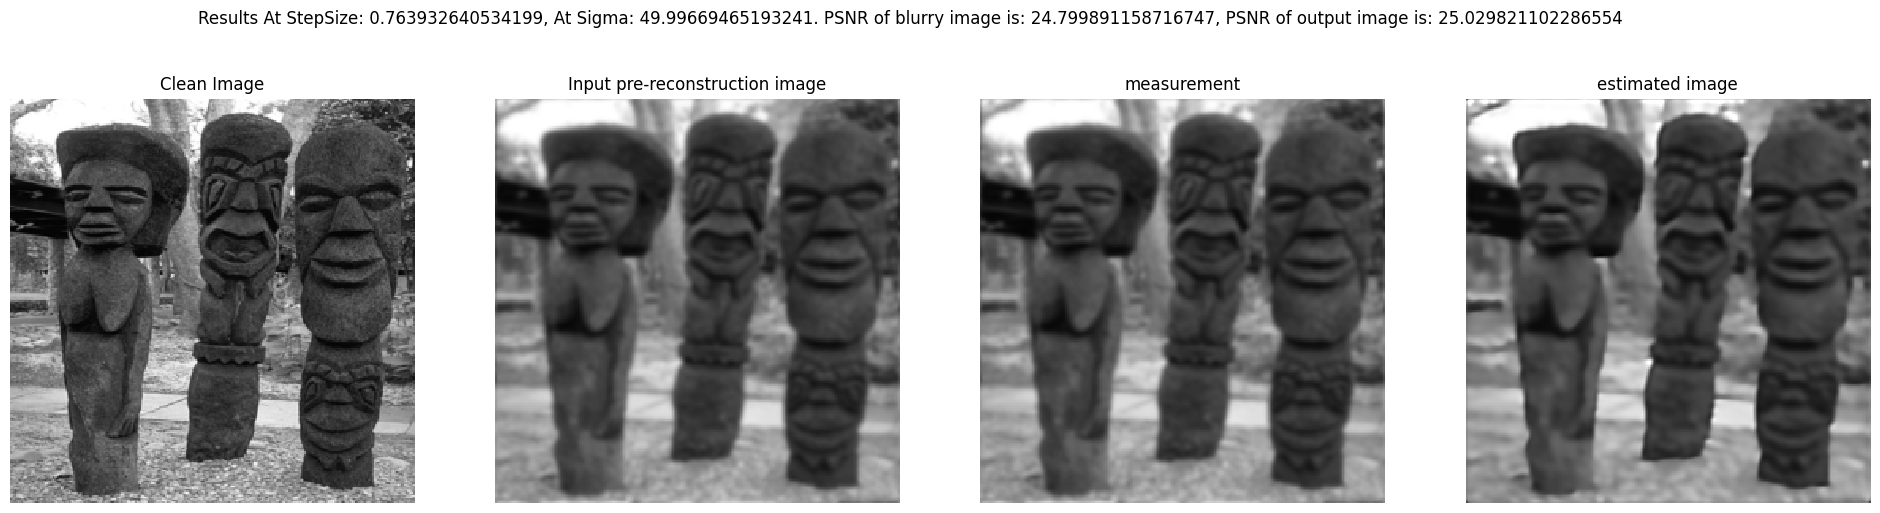

In [46]:
blurry_img_np = blurry_img.cpu().detach().numpy() if blurry_img.is_cuda else blurry_img.detach().numpy()
clean_img_np = clean_img.cpu().detach().numpy() if clean_img.is_cuda else clean_img.numpy()
recon_np = recon.cpu().detach().numpy() if recon.is_cuda else recon.numpy()
mseTermRecon = mse(clean_img_np, recon_np)
mseTermBlurred = mse(clean_img_np,blurry_img_np)

finalPsnrOutput = psnrCalc(mseTermRecon,1)
finalPsnrMeas = psnrCalc(mseTermBlurred,1)

fig, ax = plt.subplots(1,4, figsize=(24,6))

fig.suptitle(f'Results At StepSize: {bestStepsize}, At Sigma: {sigma}. PSNR of blurry image is: {finalPsnrMeas}, PSNR of output image is: {finalPsnrOutput}')

ax[0].imshow(clean_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[0].set_title("Clean Image", fontsize=12)
ax[0].axis('off')
ax[1].imshow(x0[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[1].set_title("Input pre-reconstruction image", fontsize=12)
ax[1].axis('off')
ax[2].imshow(blurry_img[0,0].cpu().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[2].set_title("measurement", fontsize=12)
ax[2].axis('off')
ax[3].imshow(recon[0,0].cpu().detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[3].set_title("estimated image", fontsize=12)
ax[3].axis('off')